In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)
from scipy import stats
from scipy.stats import norm, skew #for some statistics


In [2]:
train = pd.read_csv('/Users/user/PycharmProjects/Sales-forecast/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/Users/user/PycharmProjects/Sales-forecast/house-prices-advanced-regression-techniques/test.csv')

In [3]:
train.shape

(1460, 81)

In [4]:
test.shape

(1459, 80)

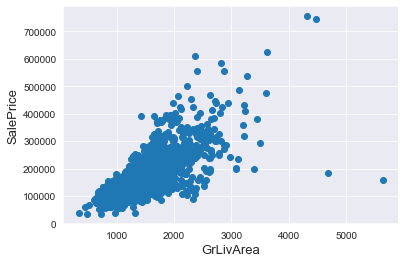

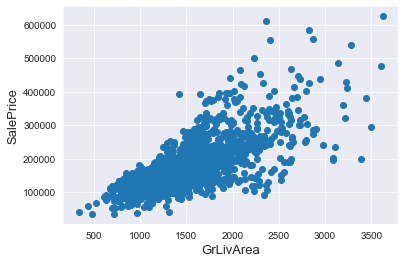

In [5]:
#show outliers
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

#Deleting outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']>700000)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()



 mu = 180151.23 and sigma = 76670.25



Text(0.5, 1.0, 'SalePrice distribution')

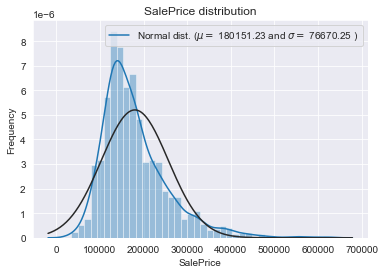

In [6]:
#SalePrice exploration
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')


In [7]:
#features engineering

#concatenate data in the same dataframe
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values



all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2915, 80)


In [8]:
#work with missing data
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.725557
MiscFeature,96.397942
Alley,93.207547
Fence,80.445969
FireplaceQu,48.713551
LotFrontage,16.672384
GarageFinish,5.454545
GarageYrBlt,5.454545
GarageQual,5.454545
GarageCond,5.454545


<AxesSubplot:>

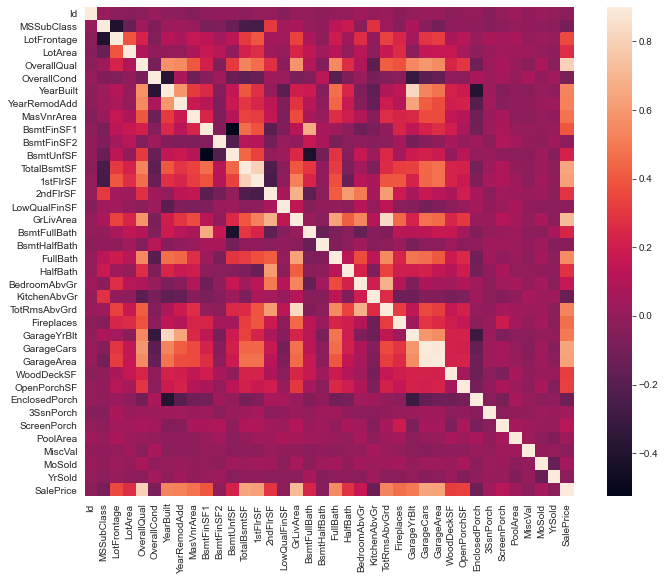

In [9]:
#Correlation map to see how features are correlated with SalePrice
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

In [10]:
#fill up missing values


#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

#all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond','PoolQC','MiscFeature','Alley','Fence','FireplaceQu'):
    all_data[col] = all_data[col].fillna('None')
    
for col in ('GarageYrBlt','MasVnrArea', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
    
for col in ('MasVnrType','Electrical','Exterior1st', 'Exterior2nd','MSZoning', 'Utilities', 'SaleType', 'KitchenQual', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

#for Functional NA means typical
all_data["Functional"] = all_data["Functional"].fillna("Typ")

In [11]:
#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


In [12]:
#Transforming some numerical variables that are really categorical
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)


#Since area features are really important we can add one more as a sum
# Adding total sqfootage feature 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

In [13]:
#Getting new train and test set

#rows from train dataset
train = all_data[:ntrain]
#rows since train dataset (test)
test = all_data[ntrain:]
all_data.shape

(2915, 81)

In [14]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [15]:
#Catboost
import numpy as np
from catboost import Pool, CatBoostRegressor

feat= np.where(train.dtypes == object)[0]

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train, y_train, train_size=0.8, random_state=1234)

train_pool = Pool(X_train, 
                  y_train, 
                  cat_features=feat)
val_pool = Pool(X_val, y_val,
                 cat_features=feat) 

test_pool = Pool(test, cat_features = feat)


In [16]:
model = CatBoostRegressor(loss_function='RMSE', 
                                       random_seed=2, 
                                       max_depth = 10,
                                       learning_rate = 0.05,
                                       random_strength=1,
                                       max_ctr_complexity=1,
                                       l2_leaf_reg=8,
                                       grow_policy = 'Lossguide',
                                
                                      )
model.fit(train_pool, eval_set = val_pool)

0:	learn: 76476.0327941	test: 63465.2411870	best: 63465.2411870 (0)	total: 91ms	remaining: 1m 30s
1:	learn: 74087.8864777	test: 61262.4994995	best: 61262.4994995 (1)	total: 123ms	remaining: 1m 1s
2:	learn: 71883.5839034	test: 59380.0148354	best: 59380.0148354 (2)	total: 154ms	remaining: 51.1s
3:	learn: 69615.1198124	test: 57370.4524383	best: 57370.4524383 (3)	total: 189ms	remaining: 47.1s
4:	learn: 67625.4128179	test: 55627.0361162	best: 55627.0361162 (4)	total: 224ms	remaining: 44.7s
5:	learn: 65774.2328610	test: 53920.6954253	best: 53920.6954253 (5)	total: 263ms	remaining: 43.6s
6:	learn: 63930.9879274	test: 52259.7877562	best: 52259.7877562 (6)	total: 317ms	remaining: 45s
7:	learn: 61939.7899382	test: 50605.1232083	best: 50605.1232083 (7)	total: 379ms	remaining: 46.9s
8:	learn: 60128.3263248	test: 49061.3963772	best: 49061.3963772 (8)	total: 411ms	remaining: 45.3s
9:	learn: 58445.9393578	test: 47631.5288927	best: 47631.5288927 (9)	total: 448ms	remaining: 44.3s
10:	learn: 56728.56875

83:	learn: 21184.3187358	test: 22592.8159008	best: 22592.8159008 (83)	total: 4.26s	remaining: 46.5s
84:	learn: 21030.6285441	test: 22539.6971394	best: 22539.6971394 (84)	total: 4.3s	remaining: 46.3s
85:	learn: 20911.4864568	test: 22483.2015807	best: 22483.2015807 (85)	total: 4.34s	remaining: 46.1s
86:	learn: 20781.2501202	test: 22431.9097306	best: 22431.9097306 (86)	total: 4.38s	remaining: 46s
87:	learn: 20645.6955640	test: 22391.7894811	best: 22391.7894811 (87)	total: 4.42s	remaining: 45.8s
88:	learn: 20531.9826977	test: 22333.2583938	best: 22333.2583938 (88)	total: 4.46s	remaining: 45.6s
89:	learn: 20403.2821364	test: 22285.7352677	best: 22285.7352677 (89)	total: 4.51s	remaining: 45.6s
90:	learn: 20268.1112331	test: 22228.8867895	best: 22228.8867895 (90)	total: 4.55s	remaining: 45.5s
91:	learn: 20162.6027794	test: 22205.4808843	best: 22205.4808843 (91)	total: 4.59s	remaining: 45.3s
92:	learn: 20044.3373291	test: 22190.7910233	best: 22190.7910233 (92)	total: 4.63s	remaining: 45.2s
93:

168:	learn: 15173.5952761	test: 21088.8740846	best: 21072.4499651 (162)	total: 8.12s	remaining: 39.9s
169:	learn: 15148.0516118	test: 21089.1388539	best: 21072.4499651 (162)	total: 8.16s	remaining: 39.9s
170:	learn: 15097.2229778	test: 21085.0202153	best: 21072.4499651 (162)	total: 8.21s	remaining: 39.8s
171:	learn: 15065.9228463	test: 21080.6084835	best: 21072.4499651 (162)	total: 8.25s	remaining: 39.7s
172:	learn: 15017.0542935	test: 21072.5372896	best: 21072.4499651 (162)	total: 8.28s	remaining: 39.6s
173:	learn: 14993.5816598	test: 21082.3879876	best: 21072.4499651 (162)	total: 8.32s	remaining: 39.5s
174:	learn: 14940.3919773	test: 21068.3661833	best: 21068.3661833 (174)	total: 8.36s	remaining: 39.4s
175:	learn: 14881.3909965	test: 21067.3069234	best: 21067.3069234 (175)	total: 8.4s	remaining: 39.3s
176:	learn: 14845.0740147	test: 21067.6657219	best: 21067.3069234 (175)	total: 8.44s	remaining: 39.2s
177:	learn: 14824.4025940	test: 21069.4354261	best: 21067.3069234 (175)	total: 8.47

249:	learn: 13046.3852002	test: 20898.6910901	best: 20879.3161989 (229)	total: 11.4s	remaining: 34.2s
250:	learn: 13029.0305058	test: 20908.5148238	best: 20879.3161989 (229)	total: 11.4s	remaining: 34.1s
251:	learn: 13019.3104854	test: 20915.5246472	best: 20879.3161989 (229)	total: 11.5s	remaining: 34s
252:	learn: 12992.8224363	test: 20917.2054373	best: 20879.3161989 (229)	total: 11.5s	remaining: 33.9s
253:	learn: 12978.1808016	test: 20915.0635603	best: 20879.3161989 (229)	total: 11.5s	remaining: 33.9s
254:	learn: 12957.9061462	test: 20913.6771988	best: 20879.3161989 (229)	total: 11.6s	remaining: 33.8s
255:	learn: 12936.4655628	test: 20908.8431771	best: 20879.3161989 (229)	total: 11.6s	remaining: 33.7s
256:	learn: 12928.6274223	test: 20906.0270141	best: 20879.3161989 (229)	total: 11.6s	remaining: 33.7s
257:	learn: 12920.0515425	test: 20900.7513362	best: 20879.3161989 (229)	total: 11.7s	remaining: 33.6s
258:	learn: 12908.6691581	test: 20894.0904297	best: 20879.3161989 (229)	total: 11.7s

333:	learn: 11583.8485456	test: 20840.0817208	best: 20830.7838499 (324)	total: 14.6s	remaining: 29s
334:	learn: 11567.5133887	test: 20832.1659413	best: 20830.7838499 (324)	total: 14.6s	remaining: 29s
335:	learn: 11545.8356888	test: 20838.4131957	best: 20830.7838499 (324)	total: 14.6s	remaining: 28.9s
336:	learn: 11542.1961719	test: 20837.6009271	best: 20830.7838499 (324)	total: 14.7s	remaining: 28.9s
337:	learn: 11529.5979113	test: 20835.3675330	best: 20830.7838499 (324)	total: 14.7s	remaining: 28.8s
338:	learn: 11508.2088572	test: 20825.5841509	best: 20825.5841509 (338)	total: 14.7s	remaining: 28.8s
339:	learn: 11497.9820956	test: 20820.0988573	best: 20820.0988573 (339)	total: 14.8s	remaining: 28.7s
340:	learn: 11490.9913084	test: 20815.0132013	best: 20815.0132013 (340)	total: 14.8s	remaining: 28.7s
341:	learn: 11481.5679580	test: 20808.2915272	best: 20808.2915272 (341)	total: 14.9s	remaining: 28.6s
342:	learn: 11473.6811787	test: 20803.0047036	best: 20803.0047036 (342)	total: 14.9s	r

417:	learn: 10372.9681947	test: 20717.5331135	best: 20682.3935959 (407)	total: 17.9s	remaining: 24.9s
418:	learn: 10345.2766814	test: 20716.9350690	best: 20682.3935959 (407)	total: 17.9s	remaining: 24.8s
419:	learn: 10339.7790218	test: 20711.0424473	best: 20682.3935959 (407)	total: 17.9s	remaining: 24.8s
420:	learn: 10320.1753880	test: 20710.4602227	best: 20682.3935959 (407)	total: 18s	remaining: 24.7s
421:	learn: 10305.1668996	test: 20719.3810921	best: 20682.3935959 (407)	total: 18s	remaining: 24.7s
422:	learn: 10274.8733764	test: 20714.8171120	best: 20682.3935959 (407)	total: 18s	remaining: 24.6s
423:	learn: 10264.9042151	test: 20721.9176344	best: 20682.3935959 (407)	total: 18.1s	remaining: 24.6s
424:	learn: 10245.9677154	test: 20718.3284174	best: 20682.3935959 (407)	total: 18.1s	remaining: 24.5s
425:	learn: 10237.6844375	test: 20713.9633458	best: 20682.3935959 (407)	total: 18.2s	remaining: 24.5s
426:	learn: 10225.2807810	test: 20713.7822271	best: 20682.3935959 (407)	total: 18.2s	rem

500:	learn: 9275.9270303	test: 20692.8757597	best: 20682.3935959 (407)	total: 21.1s	remaining: 21s
501:	learn: 9271.2705335	test: 20692.3806463	best: 20682.3935959 (407)	total: 21.2s	remaining: 21s
502:	learn: 9252.6584765	test: 20698.6881412	best: 20682.3935959 (407)	total: 21.2s	remaining: 20.9s
503:	learn: 9238.8141413	test: 20701.4183761	best: 20682.3935959 (407)	total: 21.2s	remaining: 20.9s
504:	learn: 9235.9034408	test: 20701.5350845	best: 20682.3935959 (407)	total: 21.3s	remaining: 20.8s
505:	learn: 9221.1370534	test: 20699.7365951	best: 20682.3935959 (407)	total: 21.3s	remaining: 20.8s
506:	learn: 9216.2976941	test: 20697.8936045	best: 20682.3935959 (407)	total: 21.3s	remaining: 20.8s
507:	learn: 9198.1755637	test: 20705.1223014	best: 20682.3935959 (407)	total: 21.4s	remaining: 20.7s
508:	learn: 9181.5015881	test: 20707.9484788	best: 20682.3935959 (407)	total: 21.4s	remaining: 20.7s
509:	learn: 9166.3815116	test: 20712.0521085	best: 20682.3935959 (407)	total: 21.5s	remaining: 

587:	learn: 8387.9173205	test: 20590.3798253	best: 20588.8810102 (586)	total: 24.5s	remaining: 17.2s
588:	learn: 8375.5183951	test: 20577.8872566	best: 20577.8872566 (588)	total: 24.6s	remaining: 17.2s
589:	learn: 8359.4876377	test: 20571.3286628	best: 20571.3286628 (589)	total: 24.6s	remaining: 17.1s
590:	learn: 8357.5504200	test: 20569.7649497	best: 20569.7649497 (590)	total: 24.7s	remaining: 17.1s
591:	learn: 8333.2170200	test: 20572.4851445	best: 20569.7649497 (590)	total: 24.7s	remaining: 17s
592:	learn: 8318.2272987	test: 20572.2109279	best: 20569.7649497 (590)	total: 24.7s	remaining: 17s
593:	learn: 8298.6594546	test: 20567.2488158	best: 20567.2488158 (593)	total: 24.8s	remaining: 16.9s
594:	learn: 8291.3714668	test: 20567.7648773	best: 20567.2488158 (593)	total: 24.8s	remaining: 16.9s
595:	learn: 8279.7960465	test: 20574.1581484	best: 20567.2488158 (593)	total: 24.9s	remaining: 16.8s
596:	learn: 8266.8157412	test: 20572.8996658	best: 20567.2488158 (593)	total: 24.9s	remaining: 

671:	learn: 7612.9115083	test: 20547.3025889	best: 20546.8769323 (670)	total: 27.8s	remaining: 13.6s
672:	learn: 7604.2249957	test: 20549.7315650	best: 20546.8769323 (670)	total: 27.9s	remaining: 13.5s
673:	learn: 7598.9584433	test: 20548.8930051	best: 20546.8769323 (670)	total: 27.9s	remaining: 13.5s
674:	learn: 7594.5628650	test: 20549.7362726	best: 20546.8769323 (670)	total: 27.9s	remaining: 13.4s
675:	learn: 7589.0562032	test: 20550.7895383	best: 20546.8769323 (670)	total: 28s	remaining: 13.4s
676:	learn: 7572.5783708	test: 20555.5080816	best: 20546.8769323 (670)	total: 28s	remaining: 13.4s
677:	learn: 7567.5044627	test: 20559.2480468	best: 20546.8769323 (670)	total: 28s	remaining: 13.3s
678:	learn: 7559.9860152	test: 20561.4703860	best: 20546.8769323 (670)	total: 28.1s	remaining: 13.3s
679:	learn: 7546.1919737	test: 20567.5410193	best: 20546.8769323 (670)	total: 28.1s	remaining: 13.2s
680:	learn: 7537.0136269	test: 20575.2288424	best: 20546.8769323 (670)	total: 28.2s	remaining: 13

758:	learn: 6934.2748739	test: 20582.0352281	best: 20546.8769323 (670)	total: 31.2s	remaining: 9.92s
759:	learn: 6932.1911750	test: 20583.3063959	best: 20546.8769323 (670)	total: 31.3s	remaining: 9.88s
760:	learn: 6926.6067850	test: 20581.7214695	best: 20546.8769323 (670)	total: 31.3s	remaining: 9.84s
761:	learn: 6920.2823850	test: 20581.0563685	best: 20546.8769323 (670)	total: 31.4s	remaining: 9.79s
762:	learn: 6910.0426695	test: 20580.7404523	best: 20546.8769323 (670)	total: 31.4s	remaining: 9.75s
763:	learn: 6907.6068871	test: 20581.4039460	best: 20546.8769323 (670)	total: 31.4s	remaining: 9.71s
764:	learn: 6905.2415280	test: 20580.7330079	best: 20546.8769323 (670)	total: 31.5s	remaining: 9.67s
765:	learn: 6896.4587190	test: 20582.7780460	best: 20546.8769323 (670)	total: 31.5s	remaining: 9.63s
766:	learn: 6889.4968350	test: 20583.1422425	best: 20546.8769323 (670)	total: 31.6s	remaining: 9.59s
767:	learn: 6877.2437749	test: 20587.4249827	best: 20546.8769323 (670)	total: 31.6s	remaini

842:	learn: 6339.7474600	test: 20594.5477504	best: 20546.8769323 (670)	total: 34.6s	remaining: 6.44s
843:	learn: 6333.3135784	test: 20595.7945443	best: 20546.8769323 (670)	total: 34.6s	remaining: 6.4s
844:	learn: 6326.0708831	test: 20597.0003991	best: 20546.8769323 (670)	total: 34.6s	remaining: 6.36s
845:	learn: 6321.3812674	test: 20597.2819488	best: 20546.8769323 (670)	total: 34.7s	remaining: 6.31s
846:	learn: 6314.5600966	test: 20594.7105986	best: 20546.8769323 (670)	total: 34.7s	remaining: 6.27s
847:	learn: 6311.1783350	test: 20592.2845580	best: 20546.8769323 (670)	total: 34.7s	remaining: 6.23s
848:	learn: 6306.9483701	test: 20591.7596930	best: 20546.8769323 (670)	total: 34.8s	remaining: 6.19s
849:	learn: 6303.5443891	test: 20595.2222328	best: 20546.8769323 (670)	total: 34.8s	remaining: 6.15s
850:	learn: 6293.6385388	test: 20591.7700737	best: 20546.8769323 (670)	total: 34.9s	remaining: 6.1s
851:	learn: 6287.8465330	test: 20595.4289962	best: 20546.8769323 (670)	total: 34.9s	remaining

926:	learn: 5831.3054717	test: 20575.4160639	best: 20546.8769323 (670)	total: 37.9s	remaining: 2.98s
927:	learn: 5829.7495926	test: 20576.1988336	best: 20546.8769323 (670)	total: 38s	remaining: 2.94s
928:	learn: 5828.4334436	test: 20575.9391658	best: 20546.8769323 (670)	total: 38s	remaining: 2.9s
929:	learn: 5819.7259947	test: 20575.9054408	best: 20546.8769323 (670)	total: 38s	remaining: 2.86s
930:	learn: 5818.2127460	test: 20576.1711849	best: 20546.8769323 (670)	total: 38.1s	remaining: 2.82s
931:	learn: 5815.3915773	test: 20575.1669501	best: 20546.8769323 (670)	total: 38.1s	remaining: 2.78s
932:	learn: 5812.4064578	test: 20574.7170417	best: 20546.8769323 (670)	total: 38.1s	remaining: 2.74s
933:	learn: 5807.3376902	test: 20575.5217235	best: 20546.8769323 (670)	total: 38.2s	remaining: 2.7s
934:	learn: 5802.3691702	test: 20573.5969010	best: 20546.8769323 (670)	total: 38.2s	remaining: 2.66s
935:	learn: 5795.9496790	test: 20577.4514919	best: 20546.8769323 (670)	total: 38.3s	remaining: 2.62

In [17]:
print ('Model is fitted:', model.is_fitted())
print ('Model params:', model.get_params())
print ('Resulting tree count:', model.tree_count_)

Model is fitted: True
Model params: {'learning_rate': 0.05, 'l2_leaf_reg': 8, 'loss_function': 'RMSE', 'random_seed': 2, 'max_ctr_complexity': 1, 'random_strength': 1, 'max_depth': 10, 'grow_policy': 'Lossguide'}
Resulting tree count: 671


In [18]:
from catboost import cv

params = model.get_params()
params['iterations'] = 5
params['custom_loss'] = 'RMSE'


cv_data = cv(
    params = params,
    pool = train_pool,
    fold_count=2,
    type = 'Classical',
    shuffle=True,
    partition_random_seed=0
)

0:	learn: 190103.1544927	test: 190135.2246060	best: 190135.2246060 (0)	total: 100ms	remaining: 400ms
1:	learn: 182472.1729705	test: 182659.6628480	best: 182659.6628480 (1)	total: 204ms	remaining: 306ms
2:	learn: 175136.1887618	test: 175364.7397870	best: 175364.7397870 (2)	total: 266ms	remaining: 178ms
3:	learn: 168397.1229741	test: 168655.0810541	best: 168655.0810541 (3)	total: 350ms	remaining: 87.4ms
4:	learn: 162186.4805783	test: 162495.7399217	best: 162495.7399217 (4)	total: 414ms	remaining: 0us


In [19]:
np.set_printoptions(precision=3)

for name, values in cv_data.iteritems():
    print (name + ':')
    print (np.array(values))


iterations:
[0 1 2 3 4]
test-RMSE-mean:
[190135.225 182659.663 175364.74  168655.081 162495.74 ]
test-RMSE-std:
[5365.825 5258.765 4917.675 4785.08  5101.471]
train-RMSE-mean:
[190103.154 182472.173 175136.189 168397.123 162186.481]
train-RMSE-std:
[5615.462 5326.218 5682.108 5783.213 5358.453]


In [20]:
#Model performance evaluation
best_value = np.max(cv_data['test-RMSE-mean'])
best_iter = np.argmax(cv_data['test-RMSE-mean'])
print ('Best validation RMSE score: {:.2f}±{:.2f} on step {}'.format(
    best_value,
    cv_data['test-RMSE-std'][best_iter],
    best_iter
))

Best validation RMSE score: 190135.22±5365.83 on step 0


Feature importances: [1.094e-01 1.337e-01 3.467e-01 2.265e-01 1.242e+00 2.547e-03 2.145e-02
 8.738e-02 9.122e-02 1.152e-04 5.425e-02 5.358e-02 4.071e+00 5.678e-02
 1.759e-02 3.249e-01 5.419e-02 2.835e+01 4.445e-01 2.544e-01 1.274e+00
 5.982e-02 8.819e-03 1.068e-01 3.067e-02 1.372e-01 1.501e-01 2.232e+00
 2.504e-02 1.776e-01 2.747e+00 5.862e-02 4.925e-01 2.003e-01 1.243e+00
 1.842e-02 3.685e-02 3.164e-01 7.462e-01 3.276e-03 2.247e-01 2.618e-01
 8.254e-02 2.965e-01 2.045e-01 1.002e-03 2.187e+00 3.073e-01 6.159e-04
 1.627e-01 6.146e-02 3.504e-02 2.085e-02 3.428e+00 3.442e-01 1.164e-01
 3.012e-01 1.240e+00 1.064e+00 2.638e-01 9.241e-01 4.555e+00 4.093e-01
 9.570e-02 1.527e-01 1.741e-02 1.812e-01 1.367e-01 2.334e-02 2.076e-02
 7.202e-02 7.356e-03 8.875e-03 2.433e-02 4.013e-03 1.701e-03 1.356e-01
 6.764e-02 2.577e-01 4.243e-01 3.587e+01]
Feature names: ['Id' 'MSSubClass' 'MSZoning' 'LotFrontage' 'LotArea' 'Street' 'Alley'
 'LotShape' 'LandContour' 'Utilities' 'LotConfig' 'LandSlope'
 'Neighb

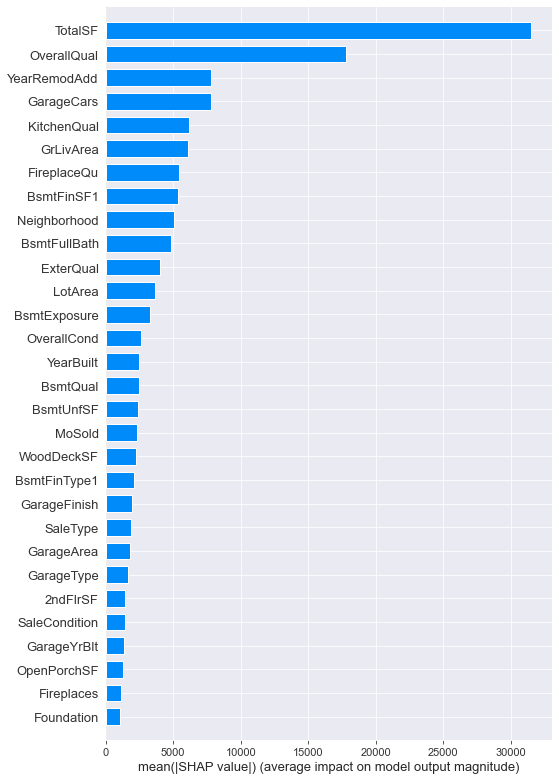

In [22]:

# Найдем самые важные факторы
importances = model.feature_importances_
print ('Feature importances:', np.array(importances))
print ('Feature names:', np.array(train_pool.get_feature_names()))


import shap
shap_values = model.get_feature_importance(train_pool, type='ShapValues')
shap.summary_plot(shap_values[:,:-1], X_train, plot_type='bar', max_display=30)

In [36]:
# Кросс-валидация
# Переобучение
# Подборка параметров
x = model.predict(test_pool)
test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 1456 to 2914
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   object 
 2   MSZoning       1459 non-null   object 
 3   LotFrontage    1459 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          1459 non-null   object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1459 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  Overa

In [38]:
submission = pd.DataFrame({'Id': test['Id'],'SalePrice':x})
#save the file to your directory
submission.to_csv('submission.csv',index=False)